# Anomaly Detection with GNN

### Import Dependencies

In [44]:
# additional lib 
import datetime
import os
from typing import Callable, Optional
import pandas as pd
import json

# visualizations
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

# modeling
from sklearn import preprocessing
import numpy as np
from torch_geometric.data import (
    Data,
    InMemoryDataset
)
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [45]:
pd.set_option('display.max_columns', None)
path = './data/hi_small_trxns.csv'
df = pd.read_csv(path)
df.head(10)
df = df.head(10)

In [46]:
###################################################################################################
# Data Visualization Function - Helpers
###################################################################################################

def format_title_output(text):
    return f"{'++' * 50}\n{text.upper()}\n{'++' * 50}\n"


#Null data with heatmap
def create_null_data_heatmap(
    title=None, 
    rotate='horizontal',
    dataset=None
):
    try:
        plt.figure(figsize=(15,5))
        sns.heatmap(dataset.isnull(), cbar=False)
        plt.title(title, fontweight='bold')
        plt.xticks(rotation=rotate)
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)


#Null data with heatmap
def create_correlation_heatmap(
    title=None,
    dataset=None
):
    try:
        plt.figure(figsize=(15,8))
        correlation = dataset.corr()
        correlation = (correlation)
        sns.heatmap(correlation, 
                    xticklabels=correlation.columns.values,
                    yticklabels=correlation.columns.values, 
                    annot=True
        )
        plt.title(title, fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)

def create_boxplots(data, columns, ncols=2, figsize=(25, 6)):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if nrows > 1 else axes
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


def create_histogram(data, column, figsize=(15, 4), color="g", kde=False):
    try:
        plt.figure(figsize=figsize)
        sns.histplot(data[column], kde=kde, color=color).set_title(f'{column[0]} Distribution', fontweight='bold')
        plt.title(f"{column[0]} Distribution", fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HISTOGRAM: ", error)
        print("**"*50)
 
###################################################################################################
# Data Preprocessing - Helpers
###################################################################################################
def detect_outliers(data, columns):
    outlier_info = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        max_outlier = outliers[col].max() if not outliers.empty else None

        outlier_info[col] = {
            "max_outlier_value": max_outlier,
            "number_of_outliers": outliers.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    return outlier_info

In [47]:
# Check the dataset info
print(format_title_output("DATASET INFO"))
print(df.info())

print(format_title_output("DATASET LENGTH"))
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           10 non-null     object 
 1   From Bank           10 non-null     int64  
 2   Account             10 non-null     object 
 3   To Bank             10 non-null     int64  
 4   Account.1           10 non-null     object 
 5   Amount Received     10 non-null     float64
 6   Receiving Currency  10 non-null     object 
 7   Amount Paid         10 non-null     float64
 8   Payment Currency    10 non-null     object 
 9   Payment Format      10 non-null     object 
 10  Is Laundering       10 non-null     int64  
dtypes: float64(2), int64(3), object(6)
memor

In [48]:
# rename the columns with lowercase and _ underscore if there is a space
print(format_title_output("DATASET NEW COLUMNS"))

df.columns = [col.lower().replace(" ", "_") for col in df.columns]
for i,j in enumerate(df.columns): 
    print(i, " : ", j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET NEW COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0  :  timestamp
1  :  from_bank
2  :  account
3  :  to_bank
4  :  account.1
5  :  amount_received
6  :  receiving_currency
7  :  amount_paid
8  :  payment_currency
9  :  payment_format
10  :  is_laundering


In [49]:
amount_consistency = df.loc[~(df['amount_received'] == df['amount_paid'])]
ccy_consistency = df.loc[~(df['receiving_currency'] == df['payment_currency'])]

print(format_title_output("AMOUNT CONSISTENCY - CREDIT & DEBIT"))
print(amount_consistency)

print(format_title_output("CURRENCY CONSISTENCY - CREDIT & DEBIT"))
print(ccy_consistency)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
AMOUNT CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Empty DataFrame
Columns: [timestamp, from_bank, account, to_bank, account.1, amount_received, receiving_currency, amount_paid, payment_currency, payment_format, is_laundering]
Index: []
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CURRENCY CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Empty DataFrame
Columns: [timestamp, from_bank, account, to_bank, account.1, amount_received, receiving_currency, amount_paid, payment_currency, payment_format, is_laundering]
Index: []


In [50]:
#Check the currency 

print("++"*50)
print("RECEIVED CURRENCY")
print("++"*50)
print(sorted(df['receiving_currency'].unique()))
print("\n\n")

print("++"*50)
print("PAYMENT CURRENCY")
print("++"*50)
print(sorted(df['payment_currency'].unique()))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECEIVED CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
['US Dollar']



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
['US Dollar']


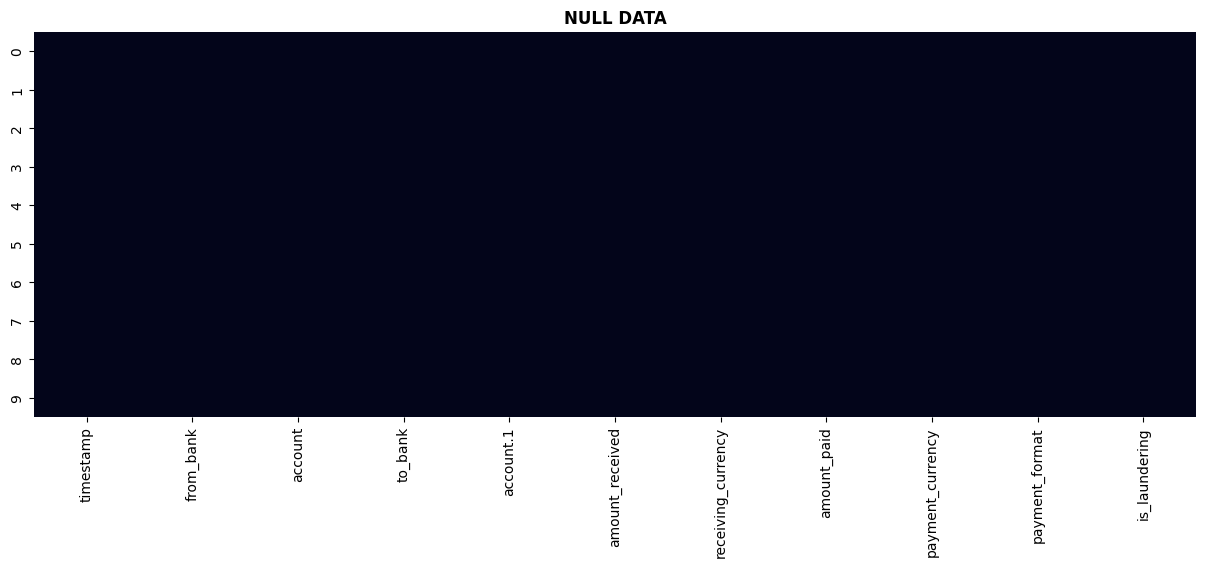

In [51]:
create_null_data_heatmap("NULL DATA", 'vertical', df)

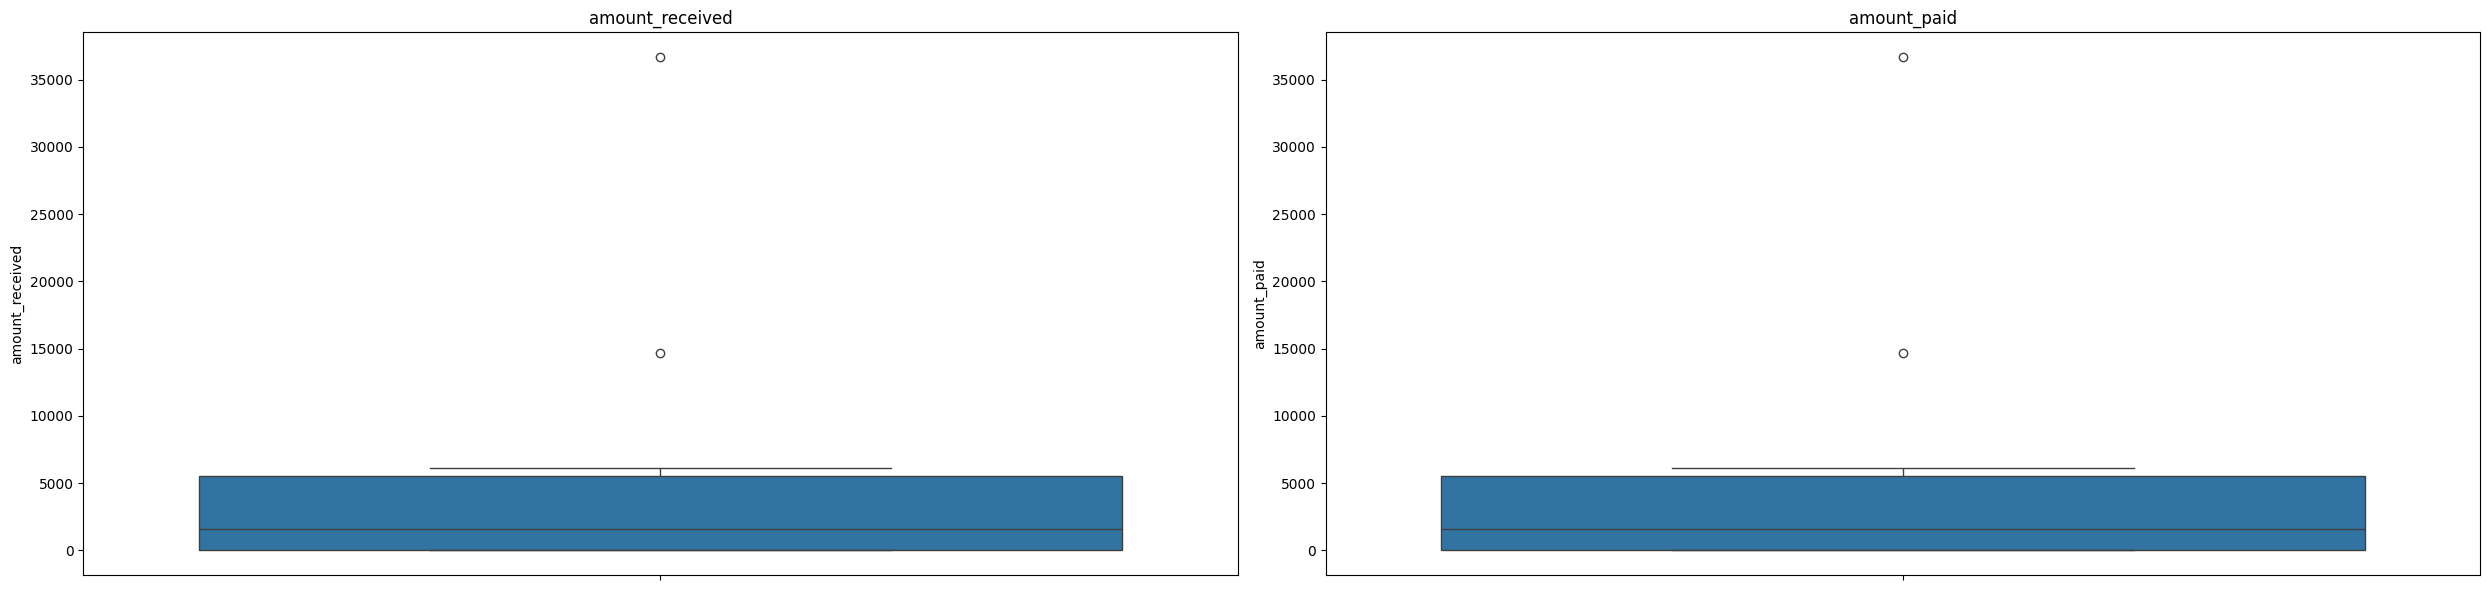

In [52]:
create_boxplots(
    df,
    ['amount_received', 'amount_paid'],
    2
)

In [53]:
outliers = detect_outliers(
    df,
    ['amount_received', 'amount_paid'],
)
print(format_title_output("OUTLIERS DETECTION - AMOUNT RECEIVED & PAID"))
print(json.dumps(outliers, indent=4))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
OUTLIERS DETECTION - AMOUNT RECEIVED & PAID
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

{
    "amount_received": {
        "max_outlier_value": 36682.97,
        "number_of_outliers": 2,
        "lower_bound": -8288.0975,
        "upper_bound": 13846.7225
    },
    "amount_paid": {
        "max_outlier_value": 36682.97,
        "number_of_outliers": 2,
        "lower_bound": -8288.0975,
        "upper_bound": 13846.7225
    }
}


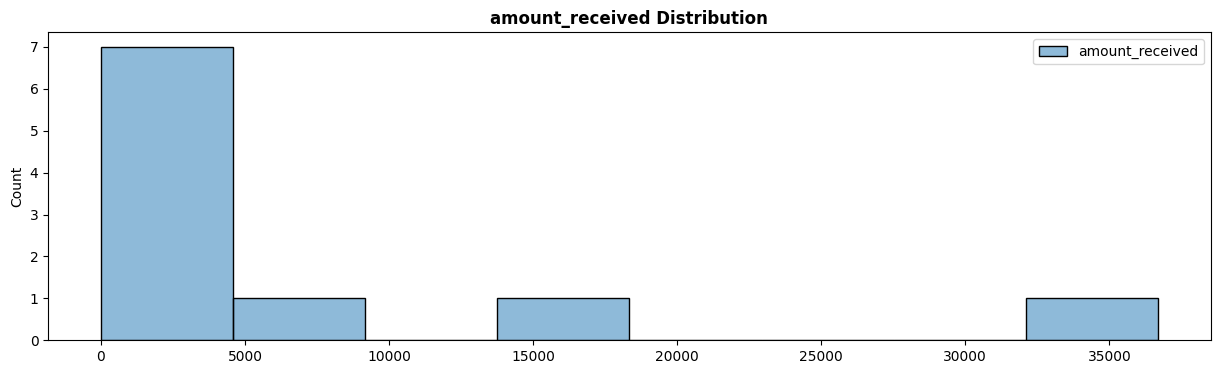

In [54]:
create_histogram(
     df,
    ['amount_received'],
)

### Data Preprocessing

In [57]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def df_label_encoder(self, columns):
        le = preprocessing.LabelEncoder()
        for col in columns:
            if col in self.df.columns:
                self.df[col] = le.fit_transform(self.df[col].astype(str))
        return self.df

    def preprocess_dataset(self):
        # Apply label encoding to the specified columns
        self.df = self.df_label_encoder(['payment_format', 'payment_currency', 'receiving_currency'])
        
        # Check if the 'Timestamp' column exists before processing
        if 'timestamp' in self.df.columns:
            # Normalize the Timestamp column
            self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
            self.df['timestamp'] = self.df['timestamp'].apply(lambda x: x.value)
            self.df['timestamp'] = (self.df['timestamp'] - self.df['timestamp'].min()) / \
                                   (self.df['timestamp'].max() - self.df['timestamp'].min())
        else:
            raise KeyError("'Timestamp' column is missing from the DataFrame")

        # Concatenate account information
        self.df['account'] = self.df['from_bank'].astype(str) + '_' + self.df['account']
        self.df['account.1'] = self.df['to_bank'].astype(str) + '_' + self.df['account.1']
        # Sort by Account column
        self.df = self.df.sort_values(by=['Account'])
        # Create the receiving and paying dataframes
        receiving_df = self.df[['account.1', 'amount_received', 'receiving_currency']]
        paying_df = self.df[['account', 'amount_paid', 'payment_currency']]
        # Rename Account.1 to Account in receiving_df
        receiving_df = receiving_df.rename({'account.1': 'account'}, axis=1)
        # Get sorted list of unique currencies
        currency_ls = sorted(self.df['receiving_currency'].unique())
        return self.df, receiving_df, paying_df, currency_ls


In [58]:
data_preprocessor = DataPreprocessor(df)
print(format_title_output("DATA PROCESSING CLASS"))
print(data_preprocessor)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATA PROCESSING CLASS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [59]:
df

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0
5,2022/09/01 00:03,1,8000F5AD0,1,8000F5AD0,6162.44,US Dollar,6162.44,US Dollar,Reinvestment,0
6,2022/09/01 00:08,1,8000EBAC0,1,8000EBAC0,14.26,US Dollar,14.26,US Dollar,Reinvestment,0
7,2022/09/01 00:16,1,8000EC1E0,1,8000EC1E0,11.86,US Dollar,11.86,US Dollar,Reinvestment,0
8,2022/09/01 00:26,12,8000EC280,2439,8017BF800,7.66,US Dollar,7.66,US Dollar,Credit Card,0
9,2022/09/01 00:21,1,8000EDEC0,211050,80AEF5310,383.71,US Dollar,383.71,US Dollar,Credit Card,0


In [60]:
df, receiving_df, paying_df, currency_ls = data_preprocessor.preprocess_dataset()
print(df.head())

KeyError: 'Account'